In [205]:
from math import pi, modf
from cmath import exp, log
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import zeta
from scipy.integrate import quad, ode

In [57]:
# complex integration
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

# Plot spectral function for fitted parameters

In [14]:
with open('./alephData/alephVpA.json') as f:
    aleph_vpa = json.load(f)['data']
data = aleph_vpa
name = 'V+A'

In [47]:
sTau = 1.77682**2
BVpA = 51.116
Be = 17.815
Vud = 0.97425
SEW = 1.0201

def kinematicWeight(x):
    return (1-x)**2*(1+2*x)

def experimental_spectral_function(s, sfm2, ds):
    return sTau/12/pi**2/SEW/Vud**2/Be/kinematicWeight(s/sTau)/ds*sfm2

rho = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['sfm2'][i], data['dsbin'][i]), range(len(data['sbin']))))
rhoErr = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['derr'][i], data['dsbin'][i]), range(len(data['sbin']))))

## Beta-function and Adler-function coefficients

In [189]:
nf = 3
nc = 3

b = np.zeros(5)
b[1] = 1/6*(11*nc - 2*nf)
b[2] = 51/4 - 19/12*nf
b[3] = 2857/64 - 5033/576*nf + 325/1728*nf**2
b[4] = 149753/768 + 891/32*zeta(3) -(1078361/20736 + 1627/864*zeta(3))*nf + (50065/20736 + 809/1296*zeta(3))*nf**2 + 1093/93312*nf**3

c = np.zeros((6,6))
c[0][0] = -5/3; c[0][1] = 1
c[1][1] = 1; c[1][2] = 0
c[2][1] = 365/24 - 11*zeta(3) - (11/12 - 2/3*zeta(3))*nf
c[2][2] = -b[1]*c[1][1]/4; c[2][3] = 0
c[3][1] = 87029/288 - 1103/4*zeta(3) + 275/6*zeta(5) +(-7847/216 + 262/9*zeta(3) -25/9*zeta(5))*nf + (151/162 -19/27 * zeta(3))*nf**2
c[3][2] = -1/4*(b[2]*c[1][1] + 2*b[1]*c[2][1])
c[3][3] = b[1]**2/12*c[1][1]; c[3][4] = 0;
c[4][1] = 78631453/20736 - 1704247/432*zeta(3) + 4185/8*zeta(3)**2 + 34165/96*zeta(5) - 1995/16*zeta(7)
c[4][2] = -1/4*(b[3]*c[1][1]+2*b[2]*c[2][1]+3*b[1]*c[3][1]);
c[4][3] = b[1]/24*(5*b[2]*c[1][1]+6*b[1]*c[2][1])
c[4][4] = -b[1]**3/32*c[1][1]; c[4][5] = 0
c[5][1] = 283
c[5][2] = 1/4*(-b[4]*c[1][1] - 2*b[3]*c[2][1]-3*b[2]*c[3][1]-4*b[1]*c[4][1]);
c[5][3] = 1/24*(12*c[3][1]*b[1]**2+6*b[1]*b[3]*c[1][1]+14*b[2]*b[1]*c[2][1]+3*b[2]**2*c[1][1]);
c[5][4] = 1/96*(-12*b[1]**3*c[2][1]-13*b[2]*b[1]**2*c[1][1])
c[5][5] = 1/80*b[1]**4*c[1][1]


## Theoretical spectral function

In [194]:
mTau = 1776.82
def theoretical_spectral_function(s, alpha):
    order = 2
    sum = 0
    for n in range(order+1):
        for k in range(n+1):
            sum = sum + nc/24/pi**3*alpha**n*k*c[n][k]*complex_quadrature(
                lambda x: log(-s*exp(-1j*x)/mTau**2)**(k-1), 0, 2*pi
            )[0]
    return sum

# following Jamin2008, Spectral function eq. 6 and e. 8
def theoretical_spectral_function_FOPT(s, alpha):
    order = 3
    sum = nc/12/pi**2
    for n in range(order+1):
        for l in range(int(modf(n-1/2)[1])+1):
            sum = sum + nc/12/pi**2*alpha**n*c[n][2*l+1]*(-pi**2)**l

    return sum

In [203]:
sLin = np.linspace(1, 3.08)
th_func = list(map(lambda x: theoretical_spectral_function_FOPT(x, 0.323), sLin))

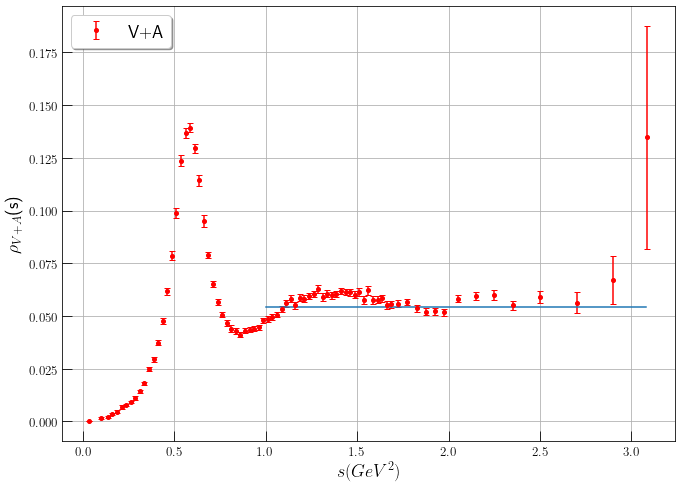

In [204]:
line = plt.errorbar(aleph_vpa['sbin'][:-1], rho[:-1], color='r', yerr=rhoErr[:-1], capsize=3, fmt='o', markersize=4, label=name)
plt.plot(sLin, scipy.real(th_func))
# axes = plt.gca()
#axes
fig = plt.gcf()
fig.set_size_inches(11,8)
fig.patch.set_facecolor('white')


plt.legend(handles=[line])
plt.ylabel(r'$\rho_{'+name+'}$(s)')
plt.xlabel('$s(GeV^2)$')
#plt.savefig(name+'.png', transparent=True)
plt.show()

In [208]:
y0, t0 = [1.0j, 2.0], 0

def beta_function(mu, alpha):
    return [1j**y[0] + y[1], -arg1*y[1]**2]
def jac(t, y, arg1):
    return [[1j*arg1, 1], [0, -arg1*2*y[1]]]


r = ode(f, jac).set_integrator('zvode', method='bdf', with_jacobian=True)
r.set_initial_value(y0, t0).set_f_params(2.0).set_jac_params(2.0)
t1 = 10
dt = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print(r.t, r.y)

1.0 [-0.71038232+0.23749653j  0.40000271+0.j        ]
2.0 [0.19098503-0.52359246j 0.22222356+0.j        ]
3.0 [0.47153208+0.52701229j 0.15384681+0.j        ]
4.0 [-0.61905937+0.30726255j  0.11764744+0.j        ]
5.0 [0.02340997-0.61418799j 0.09523835+0.j        ]
6.0 [0.58643071+0.339819j 0.08000018+0.j      ]
7.0 [-0.52070105+0.44525141j  0.06896565+0.j        ]
8.0 [-0.15986733-0.61234476j  0.06060616+0.j        ]
9.0 [0.64850462+0.15048982j 0.05405414+0.j        ]
10.0 [-0.38404699+0.56382299j  0.04878055+0.j        ]
